# Functions

In [9]:
import pandas as pd
from scipy.stats import gaussian_kde

In [10]:
%config Completer.use_jedi = False
%run 00_functions.ipynb

Import modules
Define functions


# Load stuff

## predicted vs observed

In [11]:
# recap figure with a lot of scatterplots (computed from 02_fit_various_models.ipynb and 04_genetic_algo.ipynb)

gene_names=["amacGFP","avGFP","cgreGFP","ppluGFP"]
suffixes=["lm_with_NN","sigmoid","output_subnetwork","optimised"]
# load datasets
data={gene_name:{} for gene_name in gene_names}
    
for gene_name in gene_names:
    for suffix in suffixes:
        print(gene_name,suffix)
        data[gene_name][suffix]=pd.read_csv(f"_08_Figures/for_paper/{gene_name}_{suffix}.csv")

amacGFP lm_with_NN
amacGFP sigmoid
amacGFP output_subnetwork
amacGFP optimised
avGFP lm_with_NN
avGFP sigmoid
avGFP output_subnetwork
avGFP optimised
cgreGFP lm_with_NN
cgreGFP sigmoid
cgreGFP output_subnetwork
cgreGFP optimised
ppluGFP lm_with_NN
ppluGFP sigmoid
ppluGFP output_subnetwork
ppluGFP optimised


## model complexities

In [12]:
# model complexity

model_complexity={gene_name:{} for gene_name in gene_names}

model_file=False
for gene_name in gene_names:
    for suffix in suffixes:
        
        print(gene_name,suffix)
        if suffix=="lm_with_NN":
            model_file = join(modelsPath,f"{gene_name}_lm_with_NN.h5")
        elif suffix=="sigmoid":
            model_file = join(modelsPath,f"{gene_name}_sigmoid_with_NN.h5")
        elif suffix=="output_subnetwork":
            model_file = join(modelsPath,f"{gene_name}_1_10_1_NN.h5")
        elif suffix=="optimised":
            model_file = join(modelsPath,f"{gene_name}_N1_N2_1_NN_optimized_filtered_training.h5")
        else:
            model_file=False
            
        if model_file:
            model=keras.models.load_model(model_file)
            model_complexity[gene_name][suffix]=model.count_params()


amacGFP lm_with_NN
amacGFP sigmoid
amacGFP output_subnetwork
amacGFP optimised
avGFP lm_with_NN
avGFP sigmoid
avGFP output_subnetwork
avGFP optimised
cgreGFP lm_with_NN
cgreGFP sigmoid
cgreGFP output_subnetwork
cgreGFP optimised
ppluGFP lm_with_NN
ppluGFP sigmoid
ppluGFP output_subnetwork
ppluGFP optimised


## Load potential to Fluorescence

In [13]:
p_to_F={}
p_to_F={gene_name:{} for gene_name in gene_names}

for gene_name in gene_names:
    p_to_F[gene_name]=pd.read_csv(f"_08_Figures/for_paper/{gene_name}_p_to_F.csv",index_col=0)

# Figure 4b

<b>a.</b> linear model

<b>b.</b> linear+sigmoid

<b>c.</b> linear+subnetwork

<b>d.</b> optimised model


This figure is not used as such anymore. <b>a</b>, <b>b</b>, <b>c</b> are now part of <b>figure S14</b> (see below) <br>while <b>d</b> is now <b>figure 4b</b>

Nevertheless, it is nice to have all models on the same figure for the sake of completeness

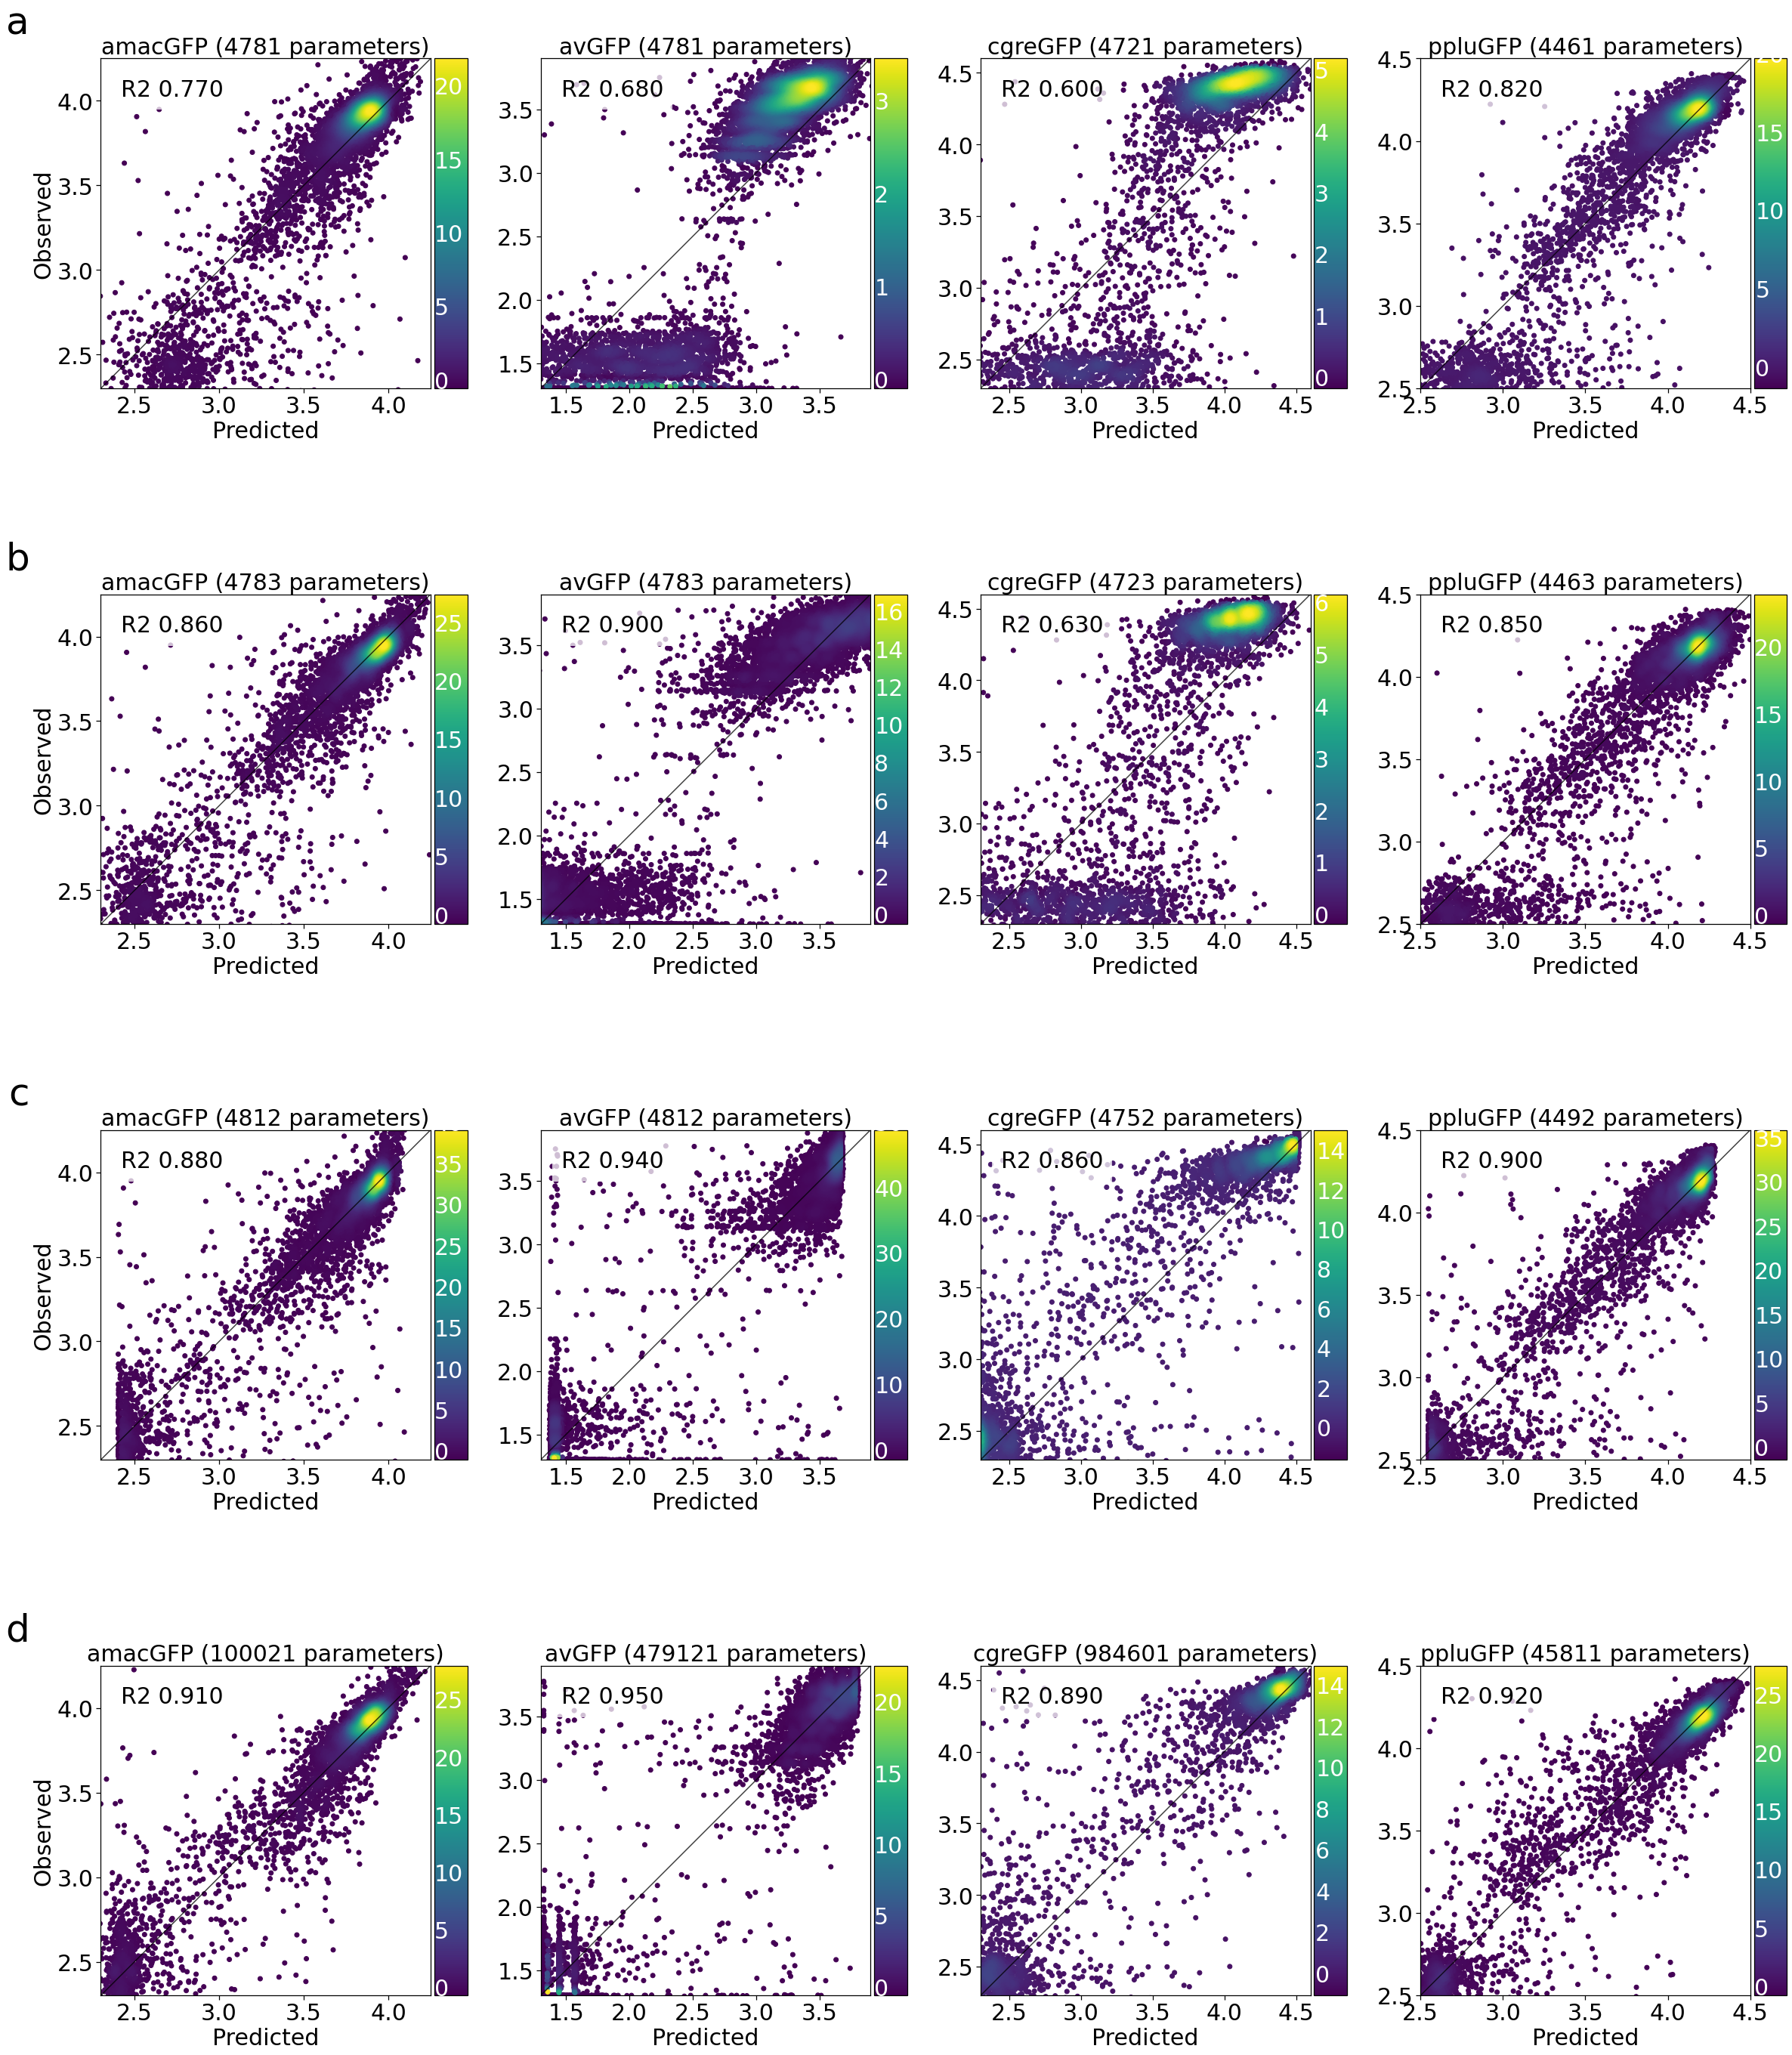

In [14]:
recompute=True

if recompute:
    
    fig, axs = plt.subplots(4,4,figsize=(40, 50),sharex=False,sharey=False)
    fig.patch.set_facecolor('w')

    i=0
    j=0

    plot_range=(1,5)
    for suffix in suffixes:    
        for gene_name in gene_names:
            if gene_name=="amacGFP":
                plot_range=(2.3,4.25)
            elif gene_name=="avGFP":
                plot_range=(1.3,3.9)
            elif gene_name=="cgreGFP":
                plot_range=(2.3,4.6)
            elif gene_name=="ppluGFP":
                plot_range=(2.5,4.5)

            x=data[gene_name][suffix]["Predicted fluorescence"]
            y=data[gene_name][suffix]["Observed fluorescence"]

            R2 = r2_score(y_pred=x,y_true=y)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            bins=50
            dat , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
            z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
                        dat , np.vstack([x,y]).T , 
                        method = "splinef2d", bounds_error = False)

            #To be sure to plot all data
            z[np.where(np.isnan(z))] = 0.0

            # Sort the points by density, so that the densest points are plotted last
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]

            im = axs[i,j].scatter( x, y, c=z, label="R2 {:.3f}".format(round(R2, 2)))

            norm = Normalize(vmin = np.min(z), vmax = np.max(z))
            cbar = fig.colorbar(cm.ScalarMappable(norm = norm), 
                                ax=axs[i,j],fraction=0.09, pad=0.01,
                                aspect=10)

            # adjust ticks
            for tick in [t for t in cbar.get_ticks() if int(t)==t]:
                cbar.ax.text(0, tick, str(int(tick)),fontsize=30,c="w")
            cbar.set_ticks([])


            leg = axs[i, j].legend(handlelength=0, handletextpad=0,
                                   fancybox=False,loc='upper left',fontsize=30,
                                   frameon=True,framealpha=0.75)
            leg.get_frame().set_linewidth(0)

            for item in leg.legendHandles:
                item.set_visible(False)

            axs[i,j].set_title(f"{gene_name} ({model_complexity[gene_name][suffix]} parameters)",fontsize=30)
            axs[i,j].set_xlim([plot_range[0], plot_range[1]])
            axs[i,j].set_ylim([plot_range[0], plot_range[1]])

            axs[i,j].plot(plot_range,plot_range, 'k-', alpha=0.75, zorder=1)

            axs[i, j].set(aspect='equal')
            axs[i, j].set_xlabel("Predicted",fontsize=30)
            if j==0:
                axs[i, j].set_ylabel("Observed",fontsize=30)

            ticks=[tick for tick in np.arange(0,5,0.5) if tick>=plot_range[0] and tick<=plot_range[1]]
            axs[i, j].set_xticks(ticks)
            axs[i, j].set_yticks(ticks)
            axs[i, j].tick_params(labelsize=30)    

            j+=1
        i+=1
        j=0

    pad=0
    for ax,txt in zip(axs[:,0],["a","b","c","d"]):
        ax.annotate(txt,
                    xy=(0,2.5),
                    xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label,
                    textcoords='offset points',
                    size=50, 
                    ha='right', 
                    va='top')


    plt.savefig(f"{figuresPath}/for_paper/use_d_for_figure_4b.svg", format="svg", dpi=50)
    plt.savefig(f"{figuresPath}/for_paper/use_d_for_figure_4b.png", format="png", dpi=50)
    
    plt.show()

# Posteriori models

Not in paper, but useful as a recap

0.8289714992287529
avGFP not available
0.8202583892843558
0.8445137766202464


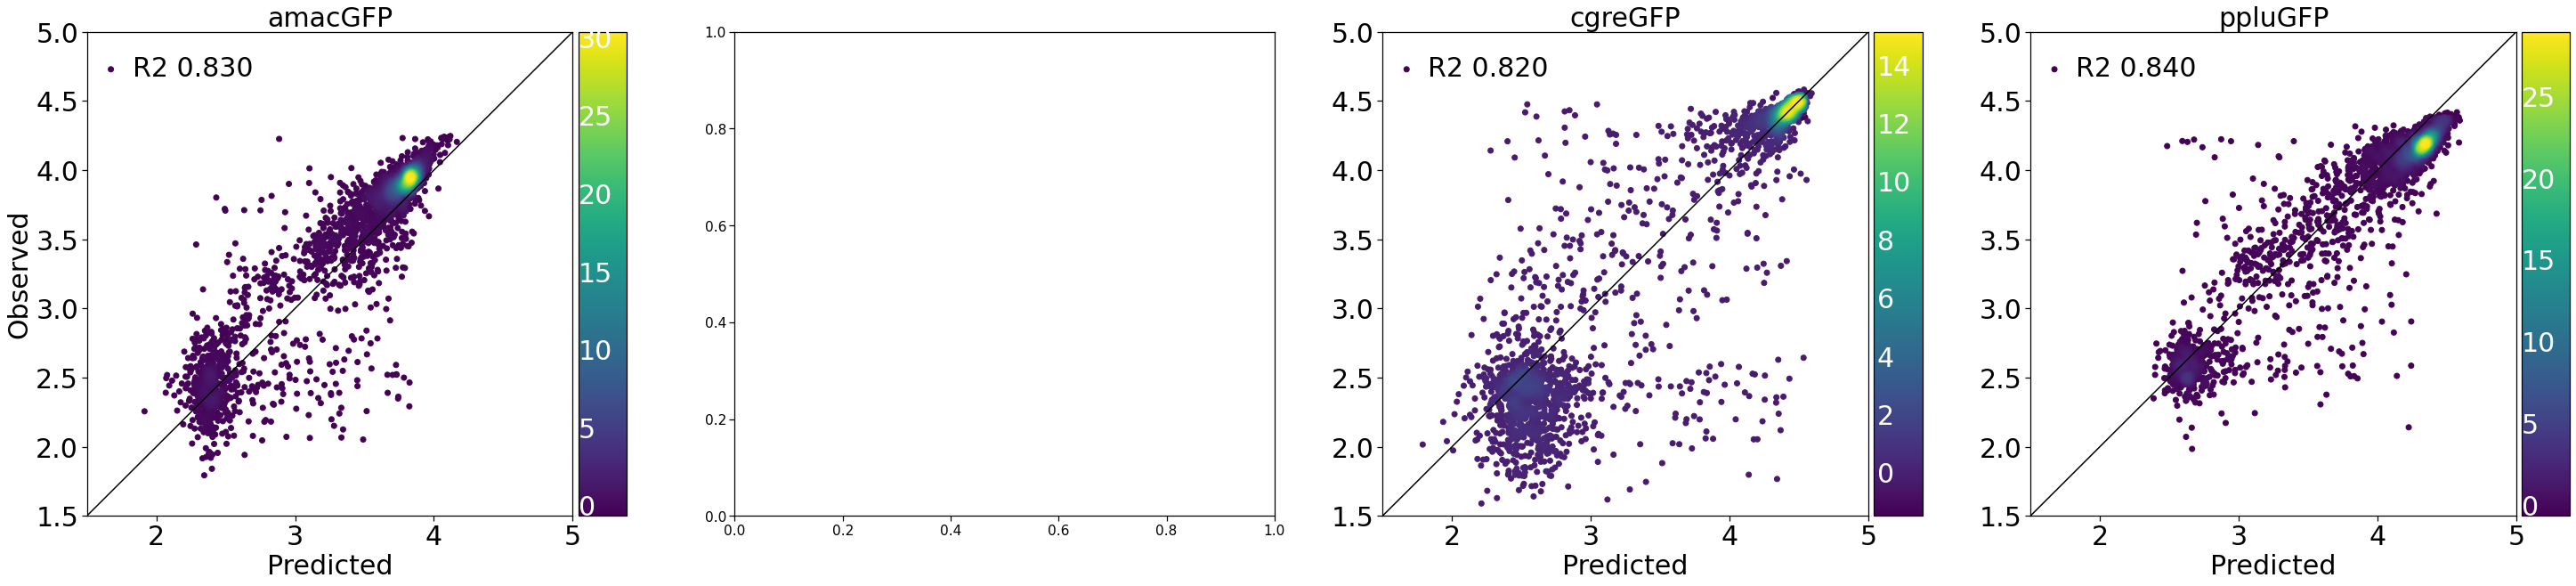

In [15]:
# plotting Katya's models
# unfortunately, no random state was defined when training Katya's models
# so I need to retrain them before I can compute their scores
# see folder katya_fig_for_paper
fig, axs = plt.subplots(1,4,figsize=(50, 10),sharex=False,sharey=False)
fig.patch.set_facecolor('w')


data_katya={}
i=0
for gene_name in gene_names:
    try:
        # load data
        data_katya[gene_name] = pd.read_csv(f"{figuresPath}/for_paper/{gene_name}_KP_model.csv",index_col=0)
        
        # compute R2 score
        x=data_katya[gene_name]["Predicted fluorescence"]
        y=data_katya[gene_name]["Observed fluorescence"]
        R2 = r2_score(y_pred=x,y_true=y)

        # scatterplot
        print(R2)


        bins=50
        dat , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
                    dat , np.vstack([x,y]).T , 
                    method = "splinef2d", bounds_error = False)

        #To be sure to plot all data
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

        im = axs[i].scatter( x, y, c=z, label="R2 {:.3f}".format(round(R2, 2)))

        norm = Normalize(vmin = np.min(z), vmax = np.max(z))
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), 
                            ax=axs[i],fraction=0.09, pad=0.01,
                            aspect=10)

        # adjust ticks
        for tick in [t for t in cbar.get_ticks() if int(t)==t]:
            cbar.ax.text(0, tick, str(int(tick)),fontsize=30,c="w")
        cbar.set_ticks([])


        axs[i].set_title(f"{gene_name}",fontsize=30)


        axs[i].set_xlabel("Predicted",fontsize=30)
        if i==0:
            axs[i].set_ylabel("Observed",fontsize=30)

        axs[i].tick_params(labelsize=30)


        leg = axs[i].legend(handlelength=0,
                            fancybox=False,loc='upper left',fontsize=30,
                            frameon=True,framealpha=0.75)

        leg.get_frame().set_linewidth(0)
        
        plot_lim=(1.5,5)
        axs[i].set_xlim(plot_lim)
        axs[i].set_ylim(plot_lim)
        axs[i].plot(plot_lim,plot_lim,"k")

    except:
        print(f"{gene_name} not available")
        
    i+=1
        


# Figure S14

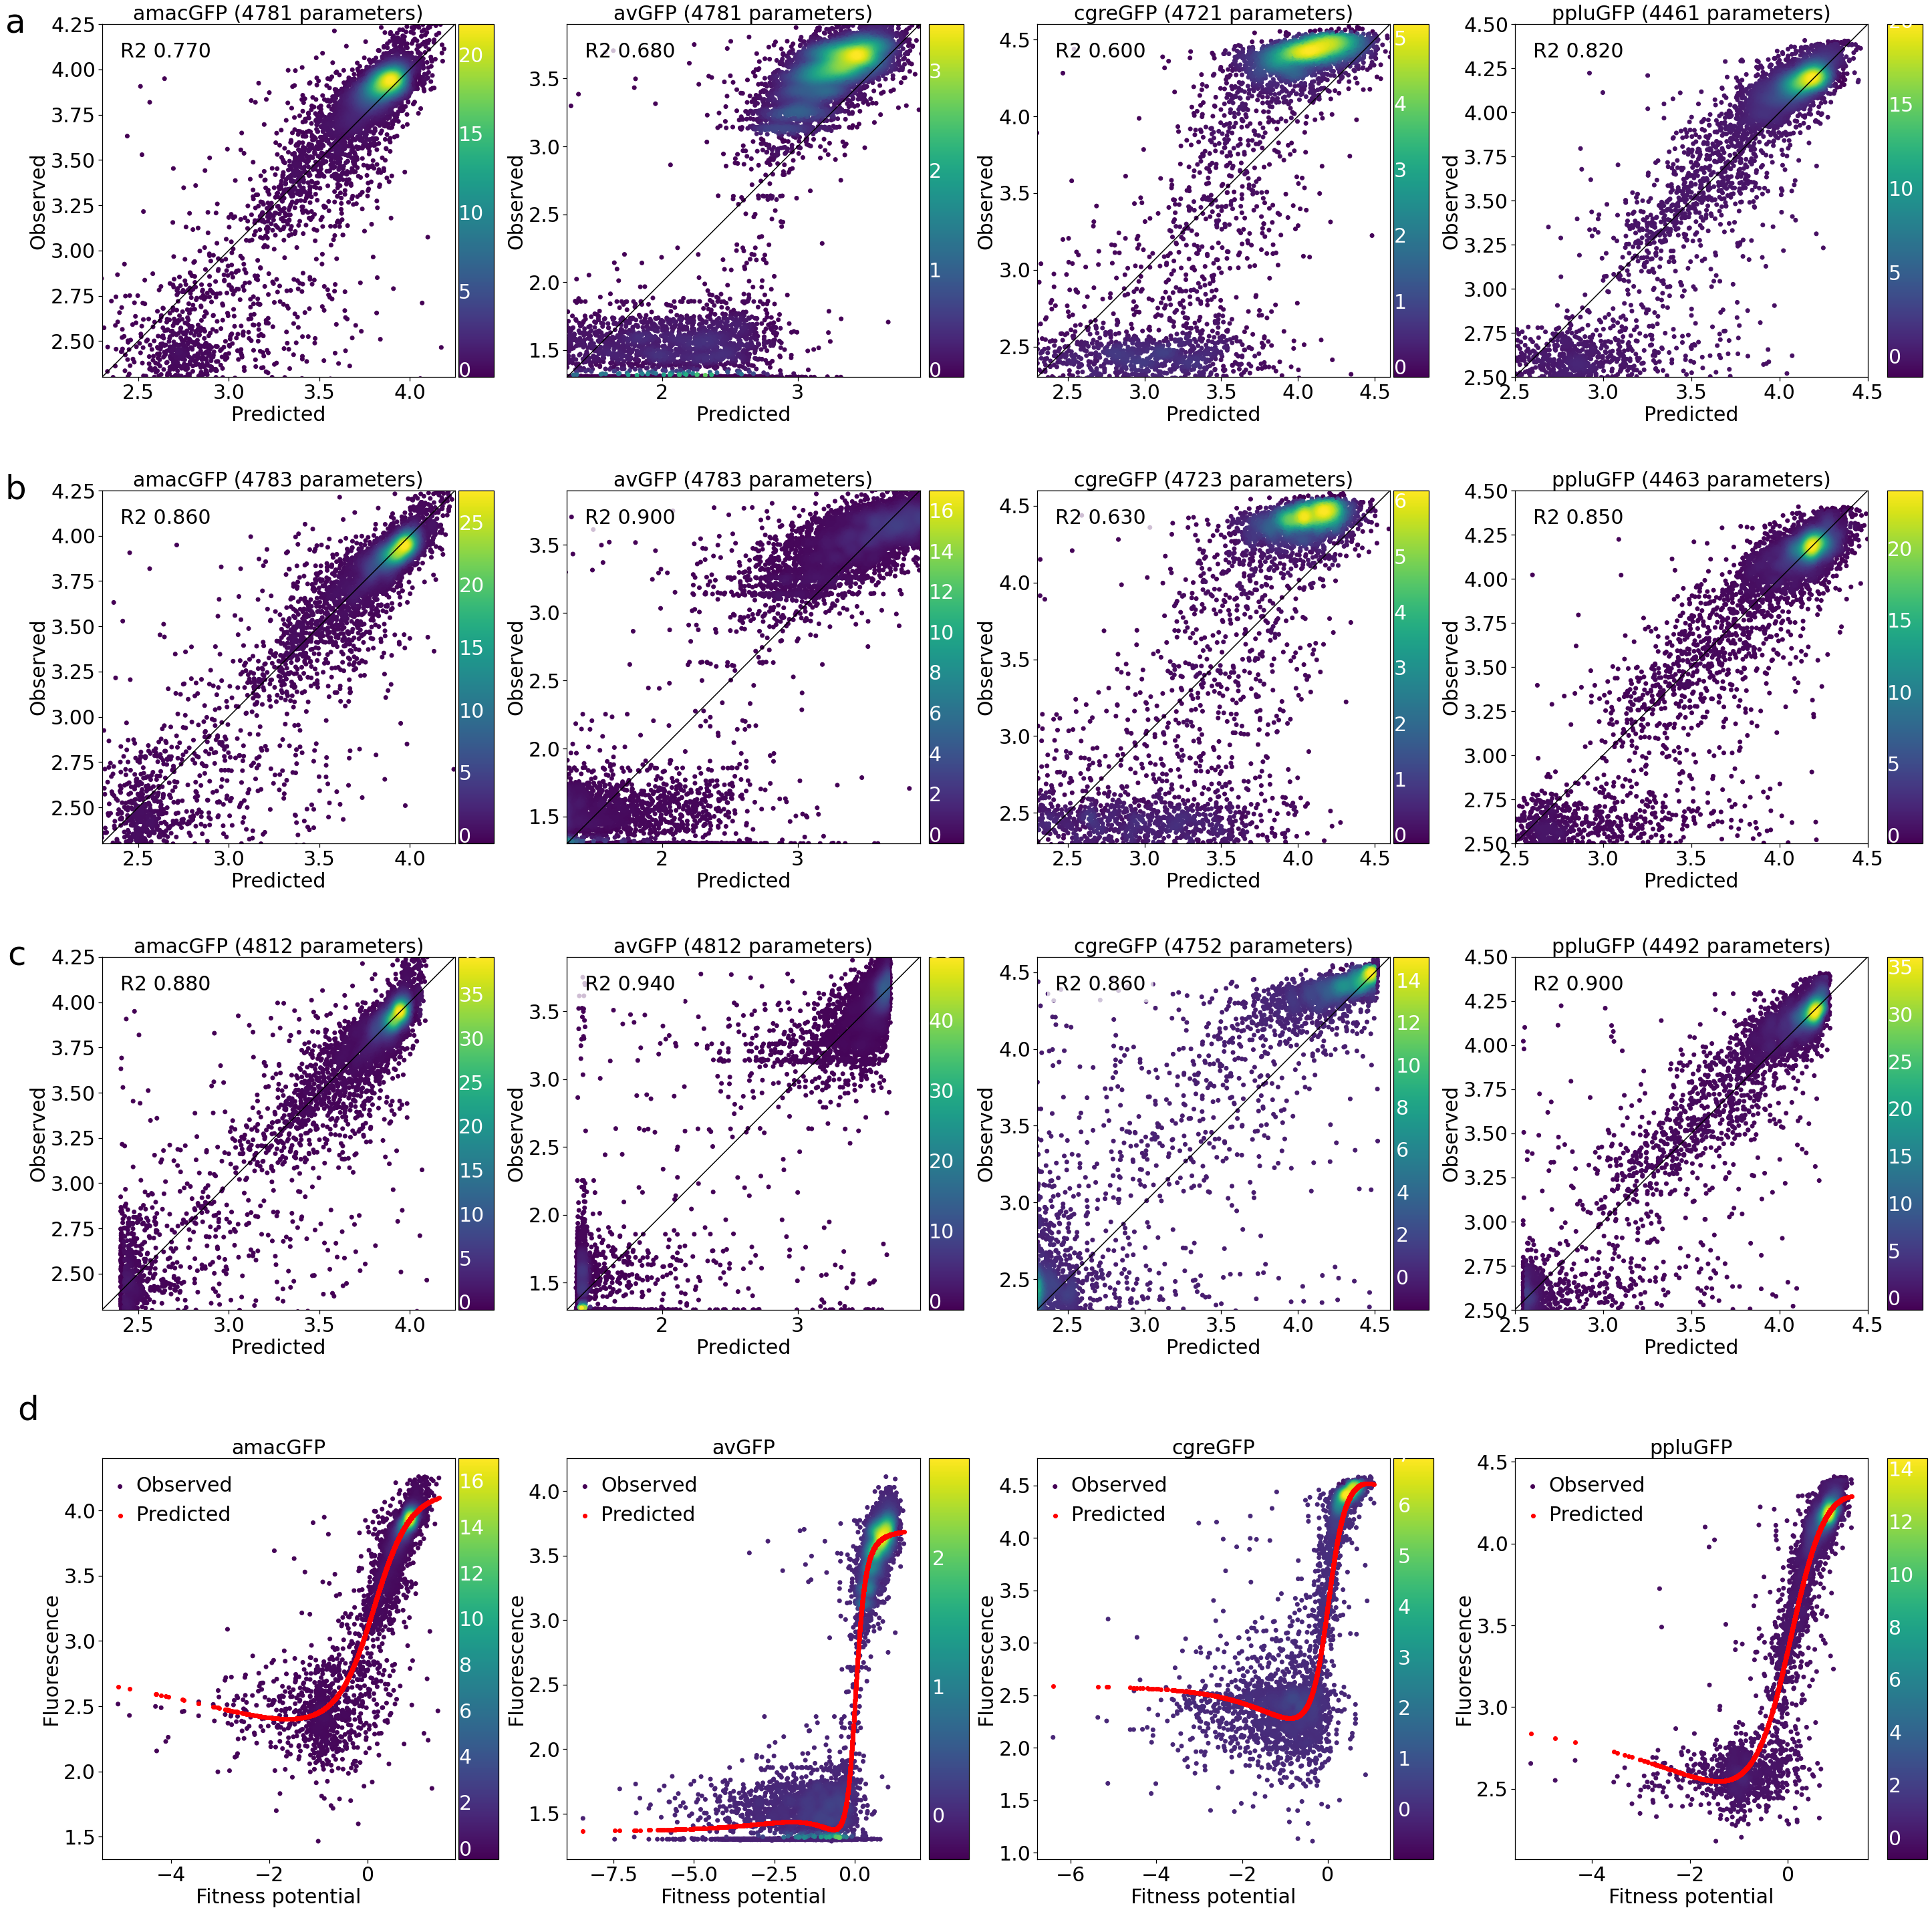

In [16]:
import matplotlib.pyplot as plt

# we are plotting the correlation predicted/observed for the linear model, linear model+sigmoid, linear model+output subnetwork
# but not the optimised model, so we are selecting only the suffixes[:-1]
# the last row is for the functions transforming the fitness potential into fluorescence level for linear model+output subnetwork
suffixes_S14=suffixes[:-1]+["potential"]


fig = plt.figure(constrained_layout=True,figsize=(40,40))
ax = fig.add_gridspec(4,4)

for gene_index,gene_name in list(enumerate(gene_names)):
    for suffix_index,suffix in list(enumerate(suffixes_S14)):
        
        # create subplot
        ax1 = fig.add_subplot(ax[suffix_index,gene_index])
        ax1.tick_params(labelsize=30)
        
        if suffix in suffixes:
            ax1.set_ylabel("Observed",fontsize=30)
            ax1.set_xlabel("Predicted",fontsize=30)
            ax1.set(aspect='equal')
            
        else:
            ax1.set_ylabel("Fluorescence",fontsize=30)

        if suffix in suffixes:
            x=data[gene_name][suffix]["Predicted fluorescence"]
            y=data[gene_name][suffix]["Observed fluorescence"]
        
        else:
            x=p_to_F[gene_name]["potential"]
            y=p_to_F[gene_name]["Observed fluorescence"]
        
        
        R2 = r2_score(y_pred=x,y_true=y)
            
        # color datapoints by density
        bins=50
        dat , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,dat , np.vstack([x,y]).T , 
                    method = "splinef2d", bounds_error = False)

        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        
        # plot datapoints
        # if we are plotting a correlation observed/predicted
        if suffix in suffixes: 
            ax1.scatter( x, y, c=z, label="R2 {:.3f}".format(round(R2, 2)))
            leg = ax1.legend(handlelength=0, handletextpad=0,fancybox=False,loc='upper left',fontsize=30,frameon=True,framealpha=0.75)
            leg.get_frame().set_linewidth(0)

            for item in leg.legendHandles:
                item.set_visible(False)
            
            # reticle
            if gene_name=="amacGFP":  plot_range=(2.3,4.25)
            elif gene_name=="avGFP":  plot_range=(1.3,3.9)
            elif gene_name=="cgreGFP":plot_range=(2.3,4.6)
            elif gene_name=="ppluGFP":plot_range=(2.5,4.5)
            ax1.set_xlim([plot_range[0], plot_range[1]])
            ax1.set_ylim([plot_range[0], plot_range[1]])
            ax1.plot(plot_range,plot_range,"k") 
        
        
        # if we are plotting the potential to fluorescence function
        if suffix=="potential": 
            ax1.scatter( x, y, c=z, label="Observed")
            ax1.set_xlabel("Fitness potential",fontsize=30)
    
            x=p_to_F[gene_name]["potential"]
            y=p_to_F[gene_name]["Predicted fluorescence"]
            im = ax1.scatter( x, y, c="red",label="Predicted")
            
            leg = ax1.legend(handlelength=0,
                        fancybox=False,loc='upper left',fontsize=30,
                        frameon=True,framealpha=0.75)
            leg.get_frame().set_linewidth(0) 
    
            
        # add colorbar
        norm = Normalize(vmin = np.min(z), vmax = np.max(z))
        
        if suffix in suffixes:
            fraction=0.1
        if suffix=="potential":
            fraction=0.2 
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), 
                            ax=ax1,fraction=fraction,
                            pad=0.01,aspect=10)
        
        # adjust colorbar ticks
        for tick in [t for t in cbar.get_ticks() if int(t)==t]:
            cbar.ax.text(0, tick, str(int(tick)),fontsize=30,c="w")
            cbar.set_ticks([])
            
        # set subfigure title
        if suffix in suffixes:
            ax1.set_title(f"{gene_name} ({model_complexity[gene_name][suffix]} parameters)",fontsize=30)
        else:
            ax1.set_title(f"{gene_name}",fontsize=30)
        
        # label subfigures
        pad=0
        if gene_index==0:
            txt=["a","b","c","d"][suffix_index]
            ax1.annotate(txt,
                        xy=(0,2.5),
                        xytext=(-ax1.yaxis.labelpad - pad, 0),
                        xycoords=ax1.yaxis.label,
                        textcoords='offset points',
                        size=50, 
                        ha='right', 
                        va='top')
            
plt.savefig(f"{figuresPath}/for_paper/suppl_fig14.svg", format="svg", dpi=50)
plt.savefig(f"{figuresPath}/for_paper/suppl_fig14.png", format="png", dpi=50)


plt.show()